In [30]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler



# Data Generation

In [3]:
class LogisticOffsetModel:
    def __init__(self, L, k, x0, b):
        self.L = L
        self.k = k
        self.x0 = x0
        self.b = b

    def __call__(self, x):
        z = np.clip(-self.k * (x - self.x0), -700, 700)
        return self.L / (1 + np.exp(z)) + self.b

    def inverse(self, y):
        """Compute x for a given y using the inverse logistic function."""
        if y <= self.b or y >= self.L + self.b:
            return np.inf  # Out of bounds
        return self.x0 - (1 / self.k) * np.log((self.L / (y - self.b)) - 1)
    
    @staticmethod
    def scale_data(x, y):
        x_scaler = MinMaxScaler()
        y_scaler = MinMaxScaler()
        x_scaled = x_scaler.fit_transform(x.reshape(-1, 1)).flatten()
        y_scaled = y_scaler.fit_transform(y.reshape(-1, 1)).flatten()
        return x_scaled, y_scaled, x_scaler, y_scaler
    
    @staticmethod
    def scale_data_manual(x, y):
        """
        Manually scale x and y data to the range [0, 1].
        
        Parameters:
        - x: Independent variable (numpy array).
        - y: Dependent variable (numpy array).
        
        Returns:
        - x_scaled: Scaled x values (numpy array).
        - y_scaled: Scaled y values (numpy array).
        - x_max: Maximum value of x (used for rescaling).
        - y_min: Minimum value of y (used for rescaling).
        - y_max: Maximum value of y (used for rescaling).
        """
        x_max = np.max(x)
        y_min, y_max = np.min(y), np.max(y)
        
        x_scaled = x / x_max
        y_scaled = (y - y_min) / (y_max - y_min)
        return x_scaled, y_scaled, x_max, y_min, y_max

    @staticmethod
    def unscale_params(params, x_scaler, y_scaler):
        L, k, x0, b = params
        x_max = x_scaler.data_max_[0]
        y_min = y_scaler.data_min_[0]
        y_max = y_scaler.data_max_[0]
        H = y_max - y_min

        # Recover original parameters
        L_orig = L * H
        b_orig = b * H + y_min
        k_orig = k / x_max
        x0_orig = x0 * x_max

        return [L_orig, k_orig, x0_orig, b_orig]
    
    @staticmethod
    def unscale_params_manual(params, x_max, y_min, y_max):
        """
        Recover original logistic parameters from scaled parameters.
        
        Parameters:
        - params: Scaled parameters [L, k, x0, b].
        - x_max: Maximum value of x (from scaling).
        - y_min: Minimum value of y (from scaling).
        - y_max: Maximum value of y (from scaling).
        
        Returns:
        - Original parameters [L, k, x0, b].
        """
        L, k, x0, b = params
        H = y_max - y_min
        
        L_orig = L * H
        b_orig = b * H + y_min
        k_orig = k / x_max
        x0_orig = x0 * x_max
        
        return [L_orig, k_orig, x0_orig, b_orig]

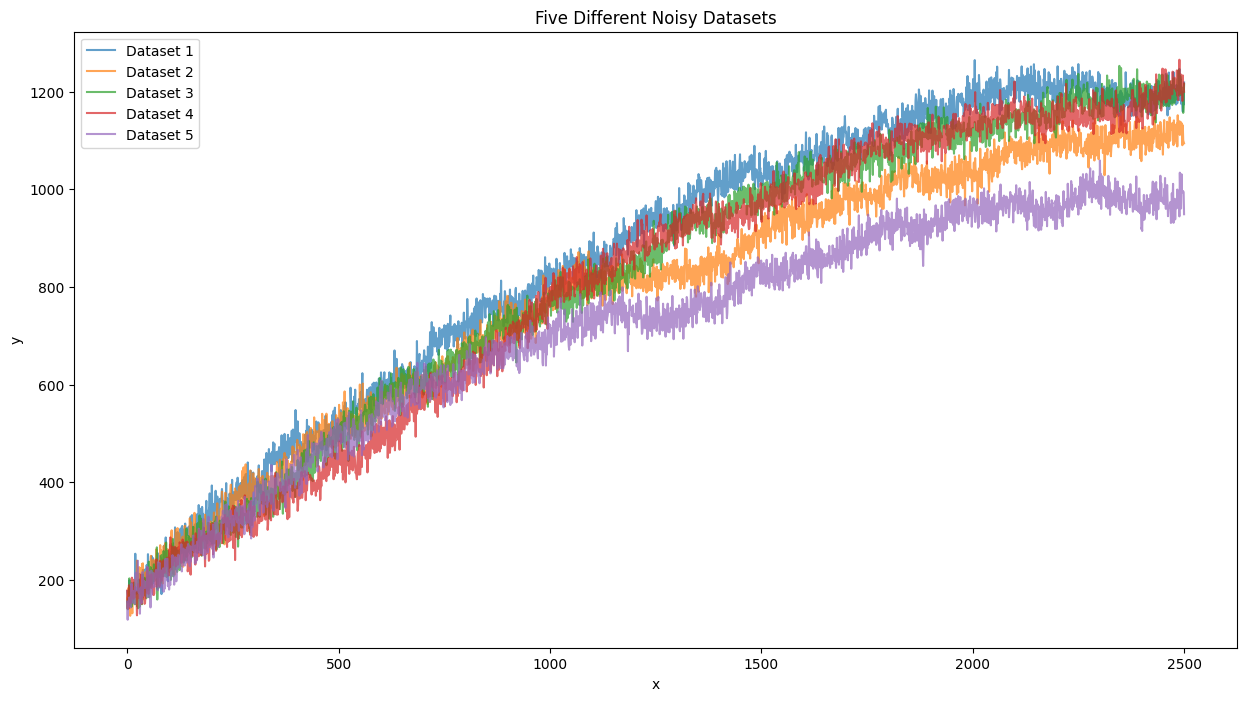

In [105]:
# Generate 5 sets of dummy data
x = np.linspace(0, 2500, 2500)
model_hist = LogisticOffsetModel(3573.300840555, np.exp(-6.8336015184), -854.9887541823, -2394.3842468484)

# Create empty arrays to store the datasets
datasets = []

# Generate 5 different datasets with varying noise patterns
for i in range(5):
    # Base signal
    y_base = model_hist(x)
    
    # Generate different noise patterns for each dataset
    noise_gaussian = np.random.normal(0, 20, len(x))
    # noise_small = np.random.normal(0, 7, len(x))
    noise_cumulative = np.cumsum(np.random.normal(0, 2, len(x)))
    
    # Combine base signal with noise
    y = y_base + noise_gaussian + noise_cumulative
    datasets.append(y)

# Optional: Visualize all datasets
plt.figure(figsize=(15, 8))
for i, y in enumerate(datasets):
    plt.plot(x, y, label=f'Dataset {i+1}', alpha=0.7)
plt.legend()
plt.title('Five Different Noisy Datasets')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Data Loader


In [101]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_len):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.seq_len = seq_len

    def __len__(self):
        return len(self.data) - self.seq_len

    def __getitem__(self, idx):
        x = self.data[idx:idx + self.seq_len]  # Input sequence
        y = self.data[idx + self.seq_len]  # Target (next value)
        return x.unsqueeze(-1), y.unsqueeze(-1)  # Add feature dim

class MultiTimeSeriesDataset(Dataset):
    def __init__(self, datasets, seq_len):
        self.datasets = [torch.tensor(data, dtype=torch.float32) for data in datasets]
        self.seq_len = seq_len
        self.total_length = sum(len(data) - seq_len for data in datasets)

    def __len__(self):
        return self.total_length

    def __getitem__(self, idx):
        # Determine which dataset and index to use
        for data in self.datasets:
            if idx < len(data) - self.seq_len:
                x = data[idx:idx + self.seq_len]
                y = data[idx + self.seq_len]
                return x.unsqueeze(-1), y.unsqueeze(-1)
            idx -= (len(data) - self.seq_len)

class OverlappingTimeSeriesDataset(Dataset):
    def __init__(self, datasets, seq_len):
        """
        Parameters:
        - datasets: List of time series arrays (one array per time series).
        - seq_len: Length of each sequence.
        """
        self.datasets = [torch.tensor(data, dtype=torch.float32) for data in datasets]
        self.seq_len = seq_len
        self.indices = self._generate_indices()

    def _generate_indices(self):
        """
        Generate indices for all valid sequences within each dataset.
        Returns:
        - A list of tuples (dataset_idx, start_idx), where:
          - dataset_idx: Index of the time series dataset.
          - start_idx: Start index of the sequence within that dataset.
        """
        indices = []
        for dataset_idx, data in enumerate(self.datasets):
            num_sequences = len(data) - self.seq_len + 1
            for start_idx in range(num_sequences):
                indices.append((dataset_idx, start_idx))
        return indices

    def __len__(self):
        return len(self.indices)
    
    def __total_sequences__(self):
        return sum(len(data) - self.seq_len + 1 for data in self.datasets)

    def __getitem__(self, idx):
        """
        Get the sequence and target for a given global index.
        Parameters:
        - idx: Global index into the combined dataset.
        Returns:
        - x: The input sequence.
        - y: The target (last value of the sequence).
        """
        dataset_idx, start_idx = self.indices[idx]
        data = self.datasets[dataset_idx]
        x = data[start_idx:start_idx + self.seq_len]  # Overlapping sequence
        y = data[start_idx + self.seq_len - 1]        # Target (last value)
        return x.unsqueeze(-1), y.unsqueeze(-1)

In [111]:

dataset_tf = OverlappingTimeSeriesDataset(datasets, 50)
dataloader = DataLoader(dataset_tf, batch_size=32, shuffle=True)


In [115]:
# Parameters
input_size = 1  # Single feature (e.g., delta pressure)
sequence_length = 50
hidden_size1 = 64
hidden_size2 = 32
num_layers = 2  # Two LSTM layers
num_epochs = 20
batch_size = 32
learning_rate = 0.001


# LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size1, num_layers=1, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size1, hidden_size2, num_layers=1, batch_first=True)
        self.fc = nn.Linear(hidden_size2, 1)  # Fully connected layer for output

    def forward(self, x):
        out, _ = self.lstm1(x)  # Pass through first LSTM
        out, _ = self.lstm2(out)  # Pass through second LSTM
        out = self.fc(out[:, -1, :])  # Take last timestep's output
        return out



In [116]:
# Instantiate model, loss function, and optimizer
model = LSTMModel(input_size, hidden_size1, hidden_size2, num_layers)


In [117]:
model

LSTMModel(
  (lstm1): LSTM(1, 64, batch_first=True)
  (lstm2): LSTM(64, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

In [ ]:
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Toy representation of LSTM Cell

In [ ]:
# Toy representation of LSTM Cell

# Redefine the environment after reset
np.set_printoptions(precision=4, suppress=True, linewidth=200)


# Dimensions
d = 1  # Input size (1 feature)
h = 2  # Hidden size (2 units) -> this is abstract representation of the sequence, bigger dimension means more complex patterns can be learned
batch_size = 1  # Batch size (1 sequence)

# Initialize weights and biases
np.random.seed(0)
W = np.random.randn(d, 4 * h)  # Input weights [d, 4h]
U = np.random.randn(h, 4 * h)  # Recurrent weights [h, 4h]
b = np.random.randn(1, 4 * h)  # Bias [1, 4h]

print("Initializing weights and biases...")
print("W: ", W, "shape: ", W.shape)
print("U: ", U, "shape: ", U.shape)
print("b: ", b, "shape: ", b.shape)

# Initialize hidden state and cell state
h_t = np.zeros((batch_size, h))  # Hidden state [batch, h]
C_t = np.zeros((batch_size, h))  # Cell state [batch, h]

# Define single sequence with 1 feature (e.g., [2, 4, 6])
X = np.array([[[2], [4], [6]]])  # Shape: [batch, timesteps, features]

# Detailed forward pass with print statements for each step
print("h_t before LSTM Forward Pass: ", h_t, "shape: ", h_t.shape)
print("C_t before LSTM Forward Pass: ", C_t, "shape: ", C_t.shape)

print("--------------------------------")

print("Starting LSTM Forward Pass...\n")

for t in range(X.shape[1]):  # Loop through each timestep
    print(f"Time step {t + 1}, Input: {X[:, t, :].flatten()}")
    
    x_t = X[:, t, :]  # Input at timestep t [batch, d]

    print("x_t * W: ", x_t, " * ", W, " = ", np.dot(x_t, W), "shape: ", np.dot(x_t, W).shape)
    print("h_t * U: ", h_t, " * ", U, " = ", np.dot(h_t, U), "shape: ", np.dot(h_t, U).shape)


    gates = np.dot(x_t, W) + np.dot(h_t, U) + b  # [batch, 4h]
    print(f"  Gates raw values: {gates.flatten()}")
    
    print("--------------------------------")

    print("Input to F gate  ", gates[:, :h])

    f_t = 1 / (1 + np.exp(-gates[:, :h]))  # Forget gate [batch, h]
    print(f"  Forget Gate (f_t): {f_t.flatten()}", "shape: ", f_t.shape)

    i_t = 1 / (1 + np.exp(-gates[:, h:2 * h]))  # Input gate [batch, h]
    print(f"  Input Gate (i_t): {i_t.flatten()}", "shape: ", i_t.shape)

    o_t = 1 / (1 + np.exp(-gates[:, 2 * h:3 * h]))  # Output gate [batch, h]
    print(f"  Output Gate (o_t): {o_t.flatten()}", "shape: ", o_t.shape)

    C_t_candidate = np.tanh(gates[:, 3 * h:])  # Candidate cell state [batch, h]
    print(f"  Candidate Cell State (C~_t): {C_t_candidate.flatten()}", "shape: ", C_t_candidate.shape)

    # Update cell state
    C_t = f_t * C_t + i_t * C_t_candidate  # [batch, h]
    print(f"  Updated Cell State (C_t): {C_t.flatten()}", "shape: ", C_t.shape)

    # Update hidden state
    h_t = o_t * np.tanh(C_t)  # [batch, h]
    print(f"  Updated Hidden State (h_t): {h_t.flatten()}", "shape: ", h_t.shape)

print("LSTM Forward Pass Completed.")